In [24]:
#import os os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0" 
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque
import heapq


random.seed(42)

#cam = cv2.VideoCapture(1) # use 0 if your device has no webcam ret, img = cam.read() cam.release() # release the camera

#if not ret: print("error: couldn't take photo") exit(1)

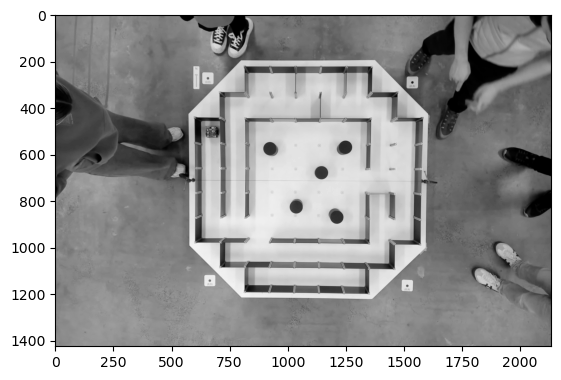

In [25]:
#cv2.imwrite("maze_img0.png", img)
seed = 42
image_file = "raw0.png"
threshold_value = 150 # for the occupancy map
autocrop_threshold_value = 145 # for the autocrop adjustment/finetuning
unsafe_kernel_size = 7
unsafe_iterations = 3

# Edge detection parameters
canny_low_threshold = 50
canny_high_threshold = 150
sobel_threshold = 50

# Task 3 - BFS
bfs_n = 10  # Wall grid size (kept for reference)
bfs_start_node = 36  # Start node (0 to 80 for 9x9 grid)
bfs_end_node = 61   # End node (0 to 80 for 9x9 grid)

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 30
prm_connection_radius = 200
prm_start_node = 20            # Start node using same grid system as BFS (0 to 80 for 9x9 grid)
prm_end_node = 60              # End node using same grid system as BFS (0 to 80 for 9x9 grid)

# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Display resulting image
plt.imshow(image, cmap = 'gray')
plt.show()

In [26]:
def _contours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE):
    """Version-agnostic cv2.findContours: always returns the contours list."""
    found = cv2.findContours(img, mode, method)
    return found[0] if len(found) == 2 else found[1]

def _find_big_octagon_contour(img_bgr):
    """Edge/contour search for the big board; prefer ~octagon near image center."""
    H, W = img_bgr.shape[:2]
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5,5), 0)
    edge = cv2.Canny(g, 50, 150)
    edge = cv2.dilate(edge, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), 2)

    # ✅ use the helper so it works on OpenCV 3 or 4
    cnts = _contours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    cx0, cy0 = W/2.0, H/2.0
    best, best_score = None, -1e18
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 0.05 * W * H:   # ignore small blobs
            continue

        x, y, w, h = cv2.boundingRect(c)
        ar_pen = abs(np.log(max(w,1) / float(max(h,1))))  # squareness penalty

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        verts = len(approx)

        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]
        d2 = (cx - cx0)**2 + (cy - cy0)**2

        # prefer big, near center, ~8 sides, square-ish bbox
        score = 0.06*area - 0.001*d2 - 6.0*abs(verts - 8) - 8.0*ar_pen
        if score > best_score:
            best_score, best = score, approx

    if best is None:
        cmax = max(cnts, key=cv2.contourArea)
        best = cv2.approxPolyDP(cmax, 0.02 * cv2.arcLength(cmax, True), True)

    return best.reshape(-1, 2).astype(np.int32)

def _white_by_hsv(img_bgr, s_max=120, v_min=85):
    """White/near-white mask using ONLY HSV (low S, high V)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    S, V = hsv[:,:,1], hsv[:,:,2]
    mask = np.where((S <= s_max) & (V >= v_min), 255, 0).astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, 1)
    return mask

def _shrink_until_white(poly_mask, white_mask, target_white=0.65, max_iter=40):
    """Iteratively erode polygon mask until enough HSV-white inside."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    m = poly_mask.copy()
    best, best_ratio = m, 0.0
    for _ in range(max_iter):
        inside = (m==255)
        area = int(inside.sum())
        if area == 0: break
        ratio = float((white_mask[inside]==255).sum()) / area
        if ratio > best_ratio: best_ratio, best = ratio, m.copy()
        if ratio >= target_white: return m
        m = cv2.erode(m, kernel, 1)
    return best

def isMaze(img_bgr,
           hsv_low=(30,0,39), hsv_high=(130,255,255),
           white_s_max=120, white_v_min=85,
           white_target=0.65, max_shrink=40,
           erode_k=9, erode_iter=1, margin_px=8):
    """
    Returns: dict with keys
      'mask'            : final octagon mask (0/255)
      'crop_rect'       : (x1,y1,x2,y2)
      'cropped_gray'    : crop from ORIGINAL grayscale (inside unchanged)
      'composite_gray'  : full image: HSV filtering applied only OUTSIDE the octagon
    """
    H,W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 1) initial octagon from edges/contours
    poly = _find_big_octagon_contour(img_bgr)
    if poly is None:
        # nothing found: return passthrough
        return {"mask": np.zeros((H,W), np.uint8), "crop_rect": (0,0,W,H),
                "cropped_gray": gray.copy(),
                "composite_gray": gray.copy()}

    poly_mask = np.zeros((H,W), np.uint8)
    cv2.fillPoly(poly_mask, [poly], 255)

    # 2) HSV-white mask and shrink polygon until white fraction is high
    white_mask = _white_by_hsv(img_bgr, s_max=white_s_max, v_min=white_v_min)
    final_mask = _shrink_until_white(poly_mask, white_mask,
                                     target_white=white_target, max_iter=max_shrink)

    # optional tiny tightening then small outward margin in crop
    if erode_iter > 0:
        final_mask = cv2.erode(final_mask,
                               cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erode_k,erode_k)),
                               erode_iter)

    ys, xs = np.where(final_mask==255)
    if len(xs)==0:
        x1,y1,x2,y2 = 0,0,W,H
    else:
        x1 = max(0, xs.min()-margin_px);  y1 = max(0, ys.min()-margin_px)
        x2 = min(W, xs.max()+1+margin_px); y2 = min(H, ys.max()+1+margin_px)

    # 3) HSV filter for OUTSIDE only
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    outside_mask = cv2.inRange(hsv, np.array(hsv_low,np.uint8), np.array(hsv_high,np.uint8))
    outside_bgr  = cv2.bitwise_and(img_bgr, img_bgr, mask=outside_mask)

    composite = img_bgr.copy()
    outside = (final_mask==0)
    composite[outside] = outside_bgr[outside]

    return {
        "mask": final_mask,
        "crop_rect": (x1,y1,x2,y2),
        "cropped_gray": gray[y1:y2, x1:x2],
        "composite_gray": cv2.cvtColor(composite, cv2.COLOR_BGR2GRAY)
    }


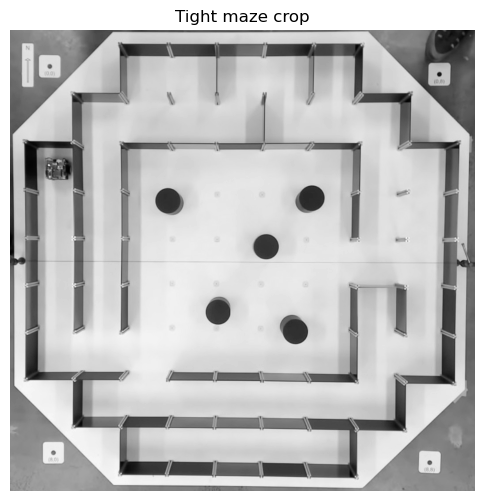

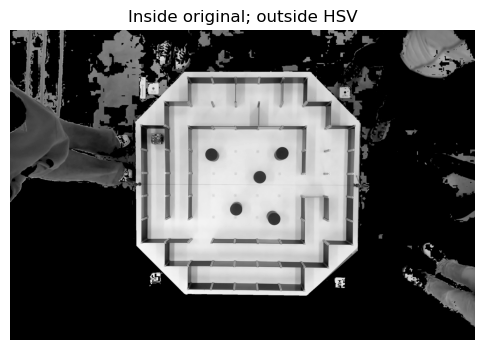

In [27]:
# 0) Load
img_color = cv2.imread(image_file, cv2.IMREAD_COLOR)
assert img_color is not None

# 1) Your HSV range (outside processing)
H_low, H_high = 30, 130
S_low, S_high = 0, 255
V_low, V_high = 39, 255

out = isMaze(
    img_color,
    hsv_low=(H_low,S_low,V_low),
    hsv_high=(H_high,S_high,V_high),
    white_s_max=120,     # how permissive 'white' is (↑ for strong shadows)
    white_v_min=85,      # min brightness for 'white'
    white_target=0.65,   # raise if you want the polygon to hug the wall more
    max_shrink=40,
    erode_k=9, erode_iter=1, margin_px=8
)

x1,y1,x2,y2 = out["crop_rect"]
cropped      = out["cropped_gray"]
composite    = out["composite_gray"]   # full frame, HSV only outside octagon

# 2) Display
plt.figure(figsize=(6,6)); plt.imshow(cropped, cmap='gray'); plt.axis('off'); plt.title('Tight maze crop'); plt.show()
plt.figure(figsize=(6,6)); plt.imshow(composite, cmap='gray'); plt.axis('off'); plt.title('Inside original; outside HSV'); plt.show()

# keep using `image` if your downstream expects it
image = cropped


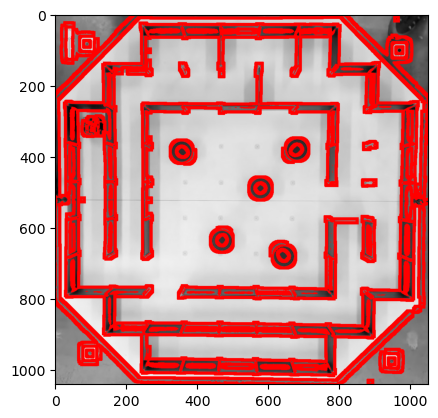

In [28]:

cropped_blur = cv2.medianBlur(cropped, 3)
binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    51, 30
)

# _, binary_obstacles = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)

# Keep the rest the same
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=unsafe_iterations)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]

plt.imshow(colour_image); plt.show()

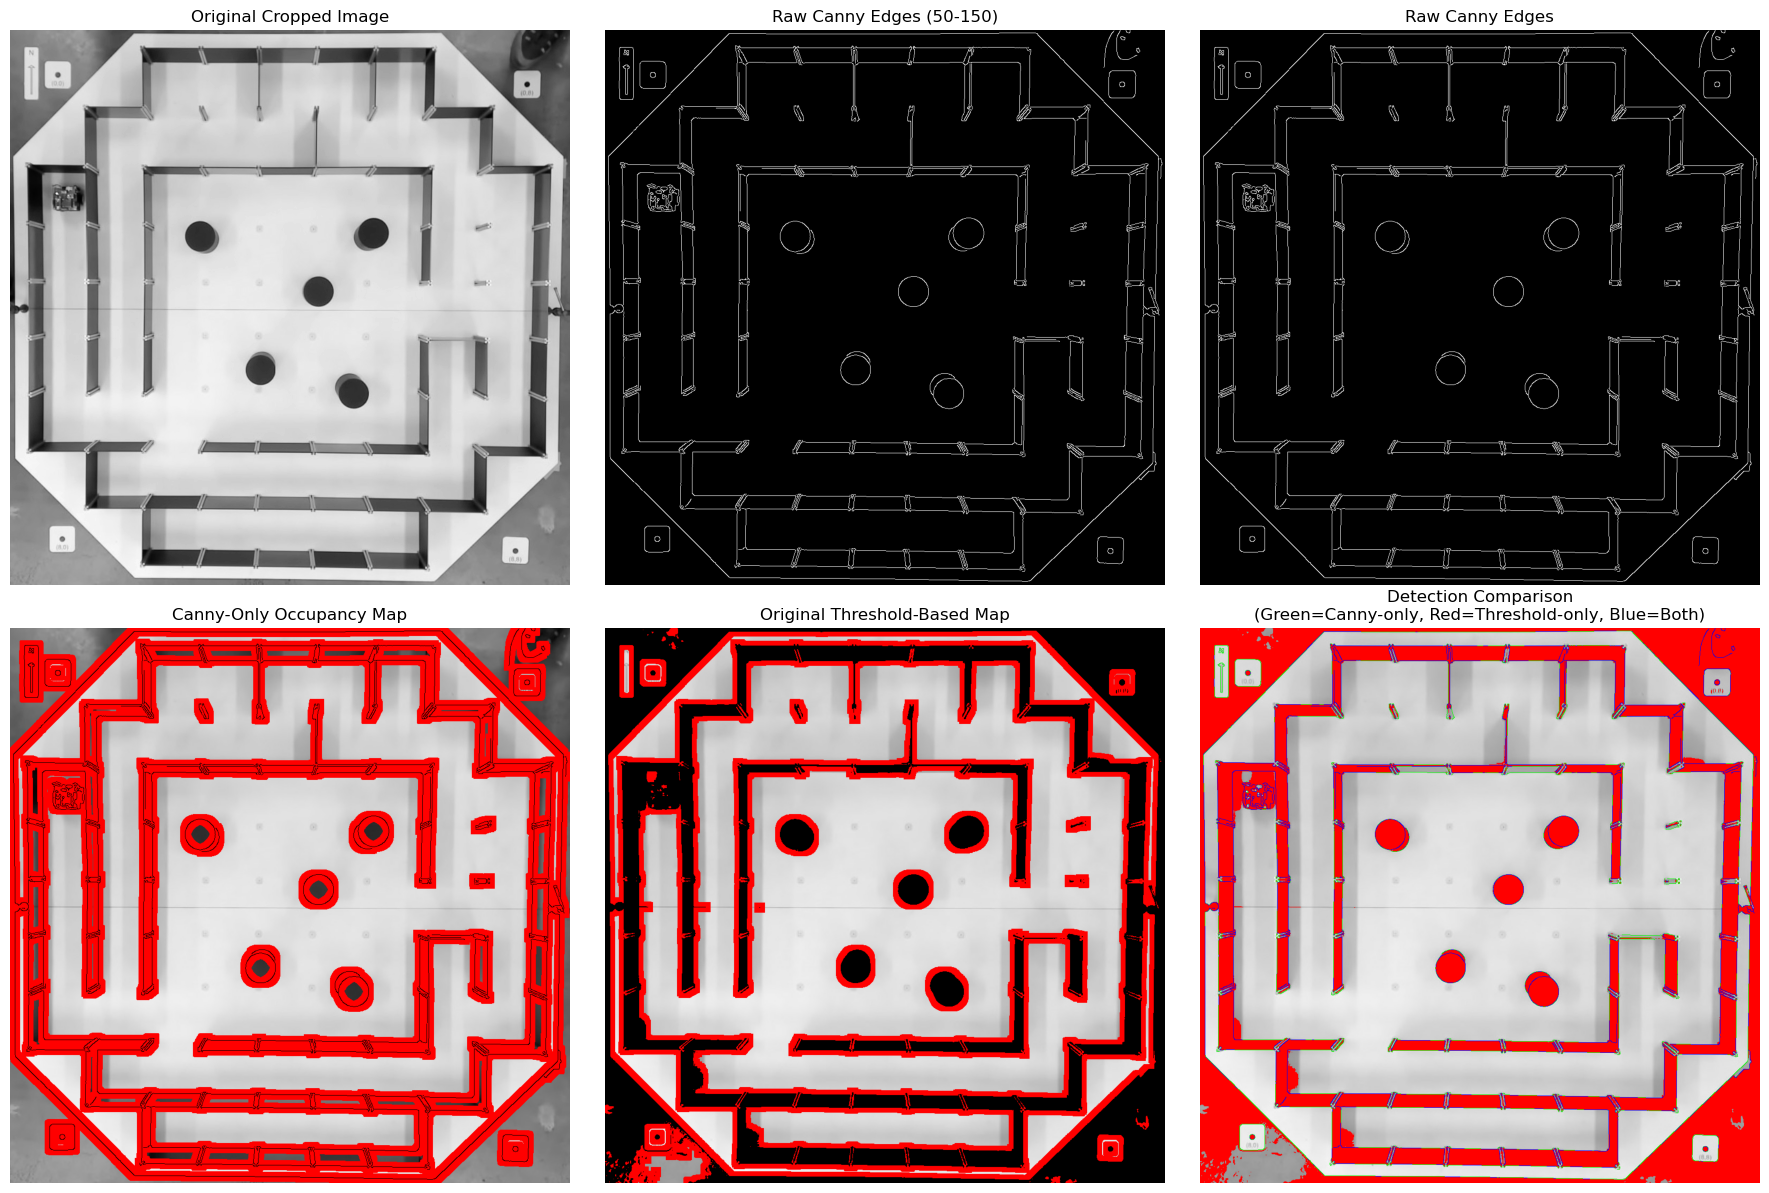

Raw Canny-Only vs Threshold Comparison:
  Canny thresholds: 50-150
  Original threshold value: 150
  Raw Canny obstacles: 29176 pixels
  Threshold-only obstacles: 297867 pixels
  Canny-only detections: 11720 pixels
  Threshold-only detections: 280411 pixels
  Both methods detect: 17456 pixels


In [29]:
# Task 1.3 - Canny-Only Edge Detection for Occupancy Map
# Using ONLY Canny edges for obstacle detection (no threshold or Sobel)

# Apply Gaussian blur to reduce noise before edge detection
blurred = cv2.GaussianBlur(cropped, (5, 5), 0)

# Canny Edge Detection - using only this for obstacle detection
canny_edges = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)

# Create configuration space (expand obstacles) using raw Canny edges (no cleaning)
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
expanded_canny = cv2.dilate(canny_edges, kernel, iterations=unsafe_iterations)
canny_buffer = expanded_canny - canny_edges

# For comparison, also create the original threshold-based occupancy map
_, original_binary = cv2.threshold(cropped, threshold_value, 255, cv2.THRESH_BINARY_INV)
expanded_original = cv2.dilate(original_binary, kernel, iterations=unsafe_iterations)
original_buffer = expanded_original - original_binary

# Create visualization comparing Canny-only vs Original threshold approach
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original cropped image
axes[0,0].imshow(cropped, cmap='gray')
axes[0,0].set_title('Original Cropped Image')
axes[0,0].axis('off')

# Raw Canny edges
axes[0,1].imshow(canny_edges, cmap='gray')
axes[0,1].set_title(f'Raw Canny Edges ({canny_low_threshold}-{canny_high_threshold})')
axes[0,1].axis('off')

# Raw Canny edges (no morphological operations)
axes[0,2].imshow(canny_edges, cmap='gray')
axes[0,2].set_title('Raw Canny Edges')
axes[0,2].axis('off')

# Canny-only occupancy map with configuration space
canny_viz = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
canny_viz[canny_buffer == 255] = [255, 0, 0]  # Buffer zone in red
canny_viz[canny_edges == 255] = [0, 0, 0]   # Obstacles in black

axes[1,0].imshow(canny_viz)
axes[1,0].set_title('Canny-Only Occupancy Map')
axes[1,0].axis('off')

# Original threshold-based occupancy map for comparison
original_viz = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
original_viz[original_buffer == 255] = [255, 0, 0]  # Buffer zone in red
original_viz[original_binary == 255] = [0, 0, 0]    # Obstacles in black

axes[1,1].imshow(original_viz)
axes[1,1].set_title('Original Threshold-Based Map')
axes[1,1].axis('off')

# Difference visualization (what Canny detects vs threshold)
diff_viz = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
canny_only = cv2.bitwise_and(canny_edges, cv2.bitwise_not(original_binary))  # Edges not in threshold
threshold_only = cv2.bitwise_and(original_binary, cv2.bitwise_not(canny_edges))  # Threshold not in edges
both = cv2.bitwise_and(canny_edges, original_binary)  # Both methods detect

diff_viz[canny_only == 255] = [0, 255, 0]      # Green: Canny-only detections
diff_viz[threshold_only == 255] = [255, 0, 0]  # Red: Threshold-only detections  
diff_viz[both == 255] = [0, 0, 255]            # Blue: Both methods detect

axes[1,2].imshow(diff_viz)
axes[1,2].set_title('Detection Comparison\n(Green=Canny-only, Red=Threshold-only, Blue=Both)')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

print(f"Raw Canny-Only vs Threshold Comparison:")
print(f"  Canny thresholds: {canny_low_threshold}-{canny_high_threshold}")
print(f"  Original threshold value: {threshold_value}")
print(f"  Raw Canny obstacles: {np.sum(canny_edges == 255)} pixels")
print(f"  Threshold-only obstacles: {np.sum(original_binary == 255)} pixels")
print(f"  Canny-only detections: {np.sum(canny_only == 255)} pixels")
print(f"  Threshold-only detections: {np.sum(threshold_only == 255)} pixels")
print(f"  Both methods detect: {np.sum(both == 255)} pixels")

# Update the global processed image to use raw Canny-only approach
processed_image_canny = cropped.copy()
processed_image_canny[expanded_canny == 255] = 0


In [46]:
# --- Minimal graph used by make_grid_and_graph ---

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = float(x)
        self.y = float(y)

    def get_point(self):   # kept for compatibility with your later code
        return (self.x, self.y)

    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}          # id -> Node
        self.edges = {}          # id -> {neighbor_id: weight}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, int(round(x)), int(round(y)))
            self.edges[node_id] = {}


    def add_edge(self, node_id1, node_id2, weight):
        # undirected, overwrite if re-added
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = float(weight)
            self.edges[node_id2][node_id1] = float(weight)

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
        if node_id2 in self.edges and node_id1 in self.edges[node_id2]:
            del self.edges[node_id2][node_id1]

    def get_nodes(self):
        return list(self.nodes.values())

    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None


In [47]:
def _contours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE):
    found = cv2.findContours(img, mode, method)
    return found[0] if len(found) == 2 else found[1]

def _dominant_angle_deg(img_square):
    g  = cv2.GaussianBlur(img_square, (3,3), 0)
    e  = cv2.Canny(g, 50, 150)
    lines = cv2.HoughLinesP(e, 1, np.pi/180, threshold=120,
                            minLineLength=max(40, img_square.shape[1]//6),
                            maxLineGap=10)
    if lines is None: return 0.0
    angs = []
    for x1,y1,x2,y2 in lines[:,0]:
        a = np.degrees(np.arctan2(y2-y1, x2-x1))
        a = ((a + 90) % 180) - 90  # [-90,90)
        angs.append(a)
    if not angs: return 0.0
    angs = np.asarray(angs, np.float32)
    folded = ((angs + 45) % 90) - 45
    return float(np.median(folded))

def _map_pt_rot(x, y, Hinv, size, rot_deg):
    """Rotate (x,y) in canonical square around center, then map with Hinv."""
    c = size / 2.0
    a = np.deg2rad(-rot_deg)  # undo tilt
    ca, sa = np.cos(a), np.sin(a)
    xr = ca*(x-c) - sa*(y-c) + c
    yr = sa*(x-c) + ca*(y-c) + c
    p  = np.array([[[xr, yr]]], np.float32)
    return cv2.perspectiveTransform(p, Hinv)[0,0]

def detect_outer_fiducials_robust(cropped_gray,
                                  corner_frac=0.24,
                                  exclude_pad=10,
                                  bright_thr=None):
    """
    Find the 4 tiny OUTSIDE corner squares. Return TL,TR,BR,BL as float32 (4x2).
    """
    H, W = cropped_gray.shape[:2]

    # Octagon mask (exclude board)
    g  = cv2.GaussianBlur(cropped_gray, (5,5), 0)
    _, bw = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if bw.mean() < 127: bw = cv2.bitwise_not(bw)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, k, 2)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN,  k, 1)
    cnts = _contours(bw)
    if not cnts: raise RuntimeError("Could not find octagon contour.")
    c = max(cnts, key=cv2.contourArea)
    oct_mask = np.zeros_like(bw); cv2.drawContours(oct_mask, [c], -1, 255, -1)
    if exclude_pad > 0:
        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*exclude_pad+1, 2*exclude_pad+1))
        oct_mask = cv2.erode(oct_mask, se, 1)
    outside = cv2.bitwise_not(oct_mask)

    base = cv2.normalize(cropped_gray, None, 0, 255, cv2.NORM_MINMAX)
    base = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(base)

    xL, xR = int(W*corner_frac), W - int(W*corner_frac)
    yT, yB = int(H*corner_frac), H - int(H*corner_frac)
    rois = [
        (0, 0, xL, yT, (0, 0)),      # TL
        (xR, 0, W, yT, (W, 0)),      # TR
        (xR, yB, W, H, (W, H)),      # BR
        (0, yB, xL, H, (0, H)),      # BL
    ]

    def detect_in_roi(x0,y0,x1,y1, corner_xy, relax=False):
        roiI = base[y0:y1, x0:x1]; roiOut = outside[y0:y1, x0:x1]
        if bright_thr is None:
            t,_ = cv2.threshold(roiI, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            T = max(150, int(t - (10 if relax else 0)))
        else:
            T = int(bright_thr) - (10 if relax else 0)
        _, bw_g = cv2.threshold(roiI, T, 255, cv2.THRESH_BINARY)
        bw_ad   = cv2.adaptiveThreshold(roiI, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 31, -5)
        ksz = max(7, int(min(y1-y0, x1-x0)*0.22))
        ksq = cv2.getStructuringElement(cv2.MORPH_RECT, (ksz, ksz))
        toph = cv2.morphologyEx(roiI, cv2.MORPH_TOPHAT, ksq)
        _, bw_th = cv2.threshold(toph, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        m = cv2.bitwise_or(bw_g, bw_ad); m = cv2.bitwise_or(m, bw_th)
        m = cv2.bitwise_and(m, roiOut)
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8), 1)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), 1)

        cnts = _contours(m)
        if not cnts: return None
        Aroi = (x1-x0)*(y1-y0)
        area_min = (0.0008 if relax else 0.0015)*Aroi
        area_max = 0.08*Aroi
        best, best_score = None, -1e18
        for c in cnts:
            a = cv2.contourArea(c)
            if not (area_min <= a <= area_max): continue
            x,y,w,h = cv2.boundingRect(c)
            ar = w/float(h)
            if not (0.6 <= ar <= 1.4): continue
            ext = a/float(w*h)
            if ext < 0.5: continue
            cx, cy = x0 + x + w/2.0, y0 + y + h/2.0
            d2 = (cx-corner_xy[0])**2 + (cy-corner_xy[1])**2
            score = a - 0.0025*d2 - 80.0*abs(np.log(ar))
            if score > best_score:
                best_score, best = score, (cx, cy)
        return best

    pts = []
    for x0,y0,x1,y1,cxy in rois:
        p = detect_in_roi(x0,y0,x1,y1,cxy, relax=False)
        if p is None: p = detect_in_roi(x0,y0,x1,y1,cxy, relax=True)
        pts.append(p)

    if any(p is None for p in pts):
        # global fallback outside the octagon
        t,_ = cv2.threshold(base, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        _, m = cv2.threshold(base, max(150, int(t-5)), 255, cv2.THRESH_BINARY)
        m = cv2.bitwise_and(m, outside)
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8), 1)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), 1)

        cnts = _contours(m)
        pool = []
        Aimg = W*H
        area_min, area_max = 0.00002*Aimg, 0.003*Aimg
        for c in cnts:
            a = cv2.contourArea(c)
            if not (area_min <= a <= area_max): continue
            x,y,w,h = cv2.boundingRect(c)
            ar = w/float(h)
            if not (0.6 <= ar <= 1.4): continue
            ext = a/float(w*h)
            if ext < 0.5: continue
            M = cv2.moments(c)
            if M["m00"] == 0: continue
            cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]
            pool.append((cx,cy))

        corners = [(0,0),(W,0),(W,H),(0,H)]
        for i,p in enumerate(pts):
            if p is not None: continue
            if not pool:
                raise RuntimeError("Outer fiducials not found; tweak corner_frac/bright_thr.")
            cx, cy = corners[i]
            d = [((px-cx)**2 + (py-cy)**2, j) for j,(px,py) in enumerate(pool)]
            _, j = min(d, key=lambda t:t[0])
            pts[i] = pool.pop(j)

    return np.array(pts, np.float32)  # TL,TR,BR,BL

def make_grid_and_graph(
    cropped_gray,
    expanded_canny, expanded_original,
    N=9, cell_px=80,
    bright_thr=None,
    occ_thresh=0.10,
    draw_outline=True,
    overlay_base=None,
    exclude_box=(2,5,2,5)   # skip middle 4×4 (rows 2..5, cols 2..5)
):
    """
    Returns:
      overlay, centers, free_mask, grid_graph, H, Hinv, corners, tilt_deg, unsafe_warp, inner_rect
    """
    # --- find outer corner squares (TL,TR,BR,BL) ---
    corners = detect_outer_fiducials_robust(
        cropped_gray, corner_frac=0.24, exclude_pad=10, bright_thr=bright_thr
    )

    # --- homography & de-tilt ---
    size = N * cell_px
    dst  = np.array([[0,0],[size,0],[size,size],[0,size]], np.float32)
    H    = cv2.getPerspectiveTransform(corners, dst)
    Hinv = np.linalg.inv(H)
    warped = cv2.warpPerspective(cropped_gray, H, (size, size))
    tilt_deg = _dominant_angle_deg(warped)

    # --- occupancy in canonical space ---
    unsafe_union = cv2.bitwise_or(expanded_canny, expanded_original)
    unsafe_warp  = cv2.warpPerspective(unsafe_union, H, (size, size), flags=cv2.INTER_NEAREST)

    # --- centers & free mask; exclude middle block ---
    r0, r1, c0, c1 = exclude_box
    x_ex0 = c0 * cell_px;  x_ex1 = (c1+1) * cell_px
    y_ex0 = r0 * cell_px;  y_ex1 = (r1+1) * cell_px
    inner_rect = (x_ex0, y_ex0, x_ex1, y_ex1)

    free_mask = np.zeros((N,N), bool)
    centers   = np.zeros((N,N,2), np.float32)

    for r in range(N):
        for c in range(N):
            xc = (c+0.5)*cell_px; yc = (r+0.5)*cell_px
            centers[r,c] = _map_pt_rot(xc, yc, Hinv, size, tilt_deg)

            if (r0 <= r <= r1) and (c0 <= c <= c1):
                free_mask[r,c] = False
                continue

            x0 = int(c*cell_px); y0 = int(r*cell_px)
            cell = unsafe_warp[y0:y0+cell_px, x0:x0+cell_px]
            occ = (cell > 0).mean() if cell.size else 1.0
            free_mask[r,c] = (occ <= occ_thresh)

    # --- grid overlay (draw on colour image if provided) ---
    overlay = overlay_base.copy() if overlay_base is not None \
              else cv2.cvtColor(cropped_gray, cv2.COLOR_GRAY2BGR)

    # segmented lines (skip inner rectangle)
    def _seg_draw_v(x):
        A = _map_pt_rot(x, 0,     Hinv, size, tilt_deg)
        B = _map_pt_rot(x, y_ex0, Hinv, size, tilt_deg)
        cv2.line(overlay, tuple(np.int32(A)), tuple(np.int32(B)), (0,255,0), 2, cv2.LINE_AA)
        A = _map_pt_rot(x, y_ex1, Hinv, size, tilt_deg)
        B = _map_pt_rot(x, size,  Hinv, size, tilt_deg)
        cv2.line(overlay, tuple(np.int32(A)), tuple(np.int32(B)), (0,255,0), 2, cv2.LINE_AA)

    def _seg_draw_h(y):
        A = _map_pt_rot(0,     y, Hinv, size, tilt_deg)
        B = _map_pt_rot(x_ex0, y, Hinv, size, tilt_deg)
        cv2.line(overlay, tuple(np.int32(A)), tuple(np.int32(B)), (0,255,0), 2, cv2.LINE_AA)
        A = _map_pt_rot(x_ex1, y, Hinv, size, tilt_deg)
        B = _map_pt_rot(size,  y, Hinv, size, tilt_deg)
        cv2.line(overlay, tuple(np.int32(A)), tuple(np.int32(B)), (0,255,0), 2, cv2.LINE_AA)

    for i in range(1, N):
        x = i*cell_px; y = i*cell_px
        if not (x_ex0 < x < x_ex1): _seg_draw_v(x)
        if not (y_ex0 < y < y_ex1): _seg_draw_h(y)

    if draw_outline:
        cv2.polylines(overlay, [np.int32(corners)], True, (0,255,0), 2, cv2.LINE_AA)
        # (optional) draw inner box border
        for a,b in [((x_ex0,y_ex0),(x_ex1,y_ex0)),
                    ((x_ex1,y_ex0),(x_ex1,y_ex1)),
                    ((x_ex1,y_ex1),(x_ex0,y_ex1)),
                    ((x_ex0,y_ex1),(x_ex0,y_ex0))]:
            A = _map_pt_rot(a[0], a[1], Hinv, size, tilt_deg)
            B = _map_pt_rot(b[0], b[1], Hinv, size, tilt_deg)
            cv2.line(overlay, tuple(np.int32(A)), tuple(np.int32(B)), (0,255,0), 2, cv2.LINE_AA)

    # --- Graph (4-neighbour) on free cells only (outside inner) ---
    grid_graph = Graph()
    def nid(r,c): return r*N + c
    for r in range(N):
        for c in range(N):
            if free_mask[r,c]:
                x,y = centers[r,c]
                grid_graph.add_node(nid(r,c), float(x), float(y))
    for r in range(N):
        for c in range(N):
            if not free_mask[r,c]: continue
            for dr,dc in [(1,0),(0,1),(-1,0),(0,-1)]:
                r2,c2 = r+dr, c+dc
                if 0 <= r2 < N and 0 <= c2 < N and free_mask[r2,c2]:
                    p1, p2 = centers[r,c], centers[r2,c2]
                    w = float(np.hypot(p1[0]-p2[0], p1[1]-p2[1]))
                    grid_graph.add_edge(nid(r,c), nid(r2,c2), w)

    return overlay, centers, free_mask, grid_graph, H, Hinv, corners, tilt_deg, unsafe_warp, inner_rect


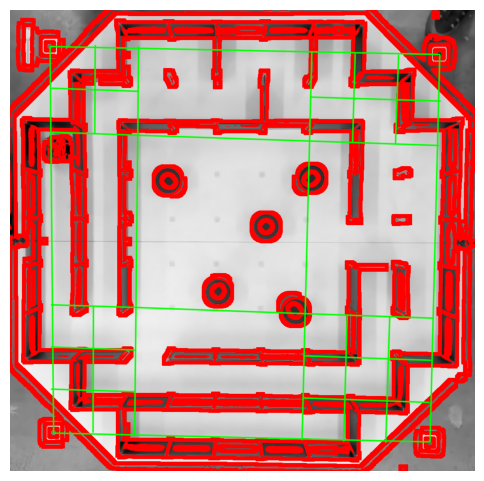

In [48]:
overlay, centers, free_mask, grid_graph, H, Hinv, corners, tilt_deg, unsafe_warp, inner_rect = make_grid_and_graph(
    cropped_gray=cropped,
    expanded_canny=expanded_canny,
    expanded_original=expanded_original,
    N=9, cell_px=80,
    bright_thr=None,      # or 190–215
    occ_thresh=0.10,
    draw_outline=True,
    overlay_base=colour_image,  # draw on your colour image
    exclude_box=(2,5,2,5)       # no grid in middle 4×4
)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)); plt.imshow(overlay); plt.axis('off'); plt.show()


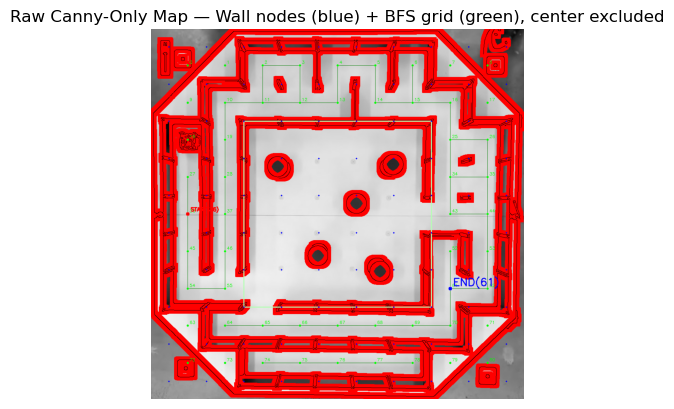

In [63]:
def path_clear(check_image, x1, y1, x2, y2, thresh=127, clearance=0):
    """
    True if the straight segment (x1,y1)->(x2,y2) is free of dark pixels.
    - thresh: values < thresh are considered obstacles (dark)
    - clearance: extra radius (in px) to check around each sample point
    """
    # ----- force plain Python ints -----
    x1 = int(round(x1)); y1 = int(round(y1))
    x2 = int(round(x2)); y2 = int(round(y2))

    # Make sure we index a single channel
    if check_image.ndim == 3:
        img = check_image[:, :, 0]
    else:
        img = check_image

    h, w = img.shape[:2]

    # ----- Bresenham (integer) -----
    dx = abs(x2 - x1)
    sx = 1 if x1 < x2 else -1
    dy = -abs(y2 - y1)   # negative per canonical form
    sy = 1 if y1 < y2 else -1
    err = dx + dy

    x, y = x1, y1
    while True:
        # bounds
        if not (0 <= x < w and 0 <= y < h):
            return False

        if clearance <= 0:
            if img[y, x] < thresh:
                return False
        else:
            # check a small square around (x, y)
            x0 = max(0, x - clearance); x1b = min(w, x + clearance + 1)
            y0 = max(0, y - clearance); y1b = min(h, y + clearance + 1)
            if (img[y0:y1b, x0:x1b] < thresh).any():
                return False

        if x == x2 and y == y2:
            break

        e2 = 2 * err
        if e2 >= dy:
            err += dy
            x += sx
        if e2 <= dx:
            err += dx
            y += sy

    return True

# ===== 1) central "hole" for PRM (grid index range, inclusive) =====
EXCL_R0, EXCL_R1 = 2, 6
EXCL_C0, EXCL_C1 = 2, 6

# ----- build both grids exactly as before -----
bfs_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)
bfs_graph = Graph()

# Make sure we have a processed image for path_clear
if 'processed_image_canny' in locals():
    processed_image = processed_image_canny
else:
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
    canny_edges = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)
    kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
    expanded_canny = cv2.dilate(canny_edges, kernel, iterations=unsafe_iterations)
    processed_image = cropped.copy()
    processed_image[expanded_canny == 255] = 0

height, width = cropped.shape[:2]
margin = 50

effective_width  = width  - 2*margin
effective_height = height - 2*margin

# Wall-aligned 10x10 (visual only)
wall_grid_n = 10
wall_grid_spacing_x = effective_width  / (wall_grid_n - 1) if wall_grid_n > 1 else 0
wall_grid_spacing_y = effective_height / (wall_grid_n - 1) if wall_grid_n > 1 else 0

wall_grid_nodes = []
for i in range(wall_grid_n):
    for j in range(wall_grid_n):
        x = margin + j * wall_grid_spacing_x
        y = margin + i * wall_grid_spacing_y
        wall_grid_nodes.append((int(round(x)), int(round(y))))

# ===== 2) 9x9 BFS grid, but SKIP the central block (2..5, 2..5) =====
bfs_grid_n = 9
for i in range(bfs_grid_n):
    for j in range(bfs_grid_n):
        # skip central area
        if EXCL_R0 <= i <= EXCL_R1 and EXCL_C0 <= j <= EXCL_C1:
            continue
        node_id = i * bfs_grid_n + j  # keep your ID scheme
        cx = margin + (j + 0.5) * wall_grid_spacing_x
        cy = margin + (i + 0.5) * wall_grid_spacing_y
        bfs_graph.add_node(node_id, int(round(cx)), int(round(cy)))

# ===== 3) Connect edges but guard for missing (skipped) nodes =====
for i in range(bfs_grid_n):
    for j in range(bfs_grid_n):
        curr_id = i * bfs_grid_n + j
        if curr_id not in bfs_graph.nodes:
            continue  # this index was skipped (in the hole)
        curr = bfs_graph.nodes[curr_id]

        # right neighbor
        if j < bfs_grid_n - 1:
            right_id = i * bfs_grid_n + (j + 1)
            if right_id in bfs_graph.nodes:
                right = bfs_graph.nodes[right_id]
                if path_clear(processed_image, curr.x, curr.y, right.x, right.y):
                    bfs_graph.add_edge(curr_id, right_id, 1)

        # bottom neighbor
        if i < bfs_grid_n - 1:
            bottom_id = (i + 1) * bfs_grid_n + j
            if bottom_id in bfs_graph.nodes:
                bottom = bfs_graph.nodes[bottom_id]
                if path_clear(processed_image, curr.x, curr.y, bottom.x, bottom.y):
                    bfs_graph.add_edge(curr_id, bottom_id, 1)

# ===== 4) Visualize: obstacles+buffer, wall nodes, BFS edges/nodes =====
if 'canny_buffer' in locals() and 'canny_edges' in locals():
    buffer_zone = canny_buffer
    obstacles   = canny_edges
else:
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
    obstacles = cv2.Canny(blurred, canny_low_threshold, canny_high_threshold)
    kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
    expanded = cv2.dilate(obstacles, kernel, iterations=unsafe_iterations)
    buffer_zone = expanded - obstacles

bfs_image_copy = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
bfs_image_copy[buffer_zone == 255] = [0, 0, 255]  # buffer in RED
bfs_image_copy[obstacles   == 255] = [0, 0, 0]    # obstacles in BLACK

# (optional) draw a light rectangle to show the excluded PRM region
hole_x0 = int(round(margin + (EXCL_C0 + 0.0) * wall_grid_spacing_x))
hole_x1 = int(round(margin + (EXCL_C1 + 1.0) * wall_grid_spacing_x))
hole_y0 = int(round(margin + (EXCL_R0 + 0.0) * wall_grid_spacing_y))
hole_y1 = int(round(margin + (EXCL_R1 + 1.0) * wall_grid_spacing_y))
cv2.rectangle(bfs_image_copy, (hole_x0, hole_y0), (hole_x1, hole_y1), (180, 255, 180), 2)

# wall grid points (blue)
for (x, y) in wall_grid_nodes:
    cv2.circle(bfs_image_copy, (int(x), int(y)), 2, (255, 0, 0), -1)

# -------- FIXED: cast to int when drawing BFS ----------
# BFS edges (green)
for u, nbrs in bfs_graph.edges.items():
    for v in nbrs:
        if u < v:  # draw once
            a = bfs_graph.nodes[u]; b = bfs_graph.nodes[v]
            A = (int(a.x), int(a.y))
            B = (int(b.x), int(b.y))
            cv2.line(bfs_image_copy, A, B, (0, 125, 0), 1)

# BFS nodes (green) + ids
for node_id, node in bfs_graph.nodes.items():
    P = (int(node.x), int(node.y))
    cv2.circle(bfs_image_copy, P, 3, (0, 255, 0), -1)
    cv2.putText(bfs_image_copy, str(node_id), (P[0] + 5, P[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

# Start/end (only if those IDs still exist after skipping the hole)
if 'bfs_start_node' in locals() and bfs_start_node in bfs_graph.nodes:
    s = bfs_graph.nodes[bfs_start_node]
    S = (int(s.x), int(s.y))
    cv2.circle(bfs_image_copy, S, 5, (0, 0, 255), -1)
    cv2.putText(bfs_image_copy, f"START({bfs_start_node})", (S[0]+8, S[1]-8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
else:
    print("Note: bfs_start_node is missing (maybe inside the excluded center).")

if 'bfs_end_node' in locals() and bfs_end_node in bfs_graph.nodes:
    t = bfs_graph.nodes[bfs_end_node]
    T = (int(t.x), int(t.y))
    cv2.circle(bfs_image_copy, T, 5, (255, 0, 0), -1)
    cv2.putText(bfs_image_copy, f"END({bfs_end_node})", (T[0]+8, T[1]-8),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
else:
    print("Note: bfs_end_node is missing (maybe inside the excluded center).")

plt.imshow(cv2.cvtColor(bfs_image_copy, cv2.COLOR_BGR2RGB))
plt.title("Raw Canny-Only Map — Wall nodes (blue) + BFS grid (green), center excluded")
plt.axis('off')
plt.show()


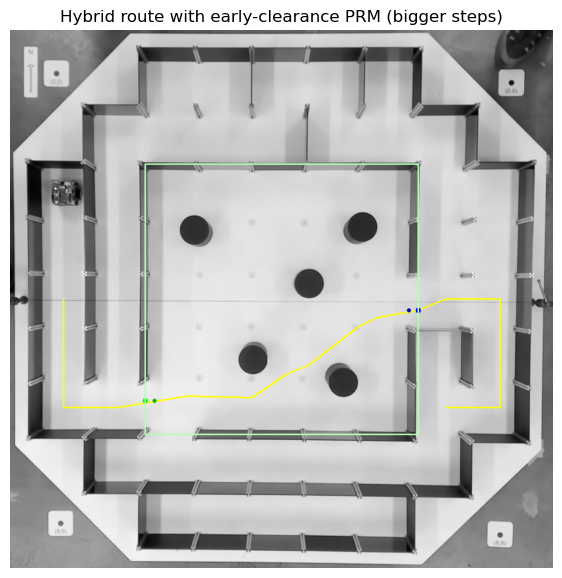

In [68]:
# ================= PRM with early clearance + bigger step =================

# ---- tune these three numbers first ----
PRM_CLEAR_PX   = 14   # robot radius + safety buffer (px)
PRM_STRIDE_PX  = 22   # sampling stride inside the PRM rectangle (bigger = longer steps)
EDGE_SAMPLE_PX = 3    # step when checking edges along a segment (px)

# --- clearance map (distance to nearest obstacle, in pixels) ---
def _build_clearance_map(img_gray, thresh=127):
    """img_gray: your processed_image (0=obstacle)."""
    ch  = img_gray[:, :, 0] if img_gray.ndim == 3 else img_gray
    free = (ch >= thresh).astype(np.uint8)  # 1=free, 0=obst
    # distanceTransform expects non-zero as "inside"
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)
    return dist  # pixels

def _segment_clear_with_dist(dist, p, q, min_clear, step=2):
    """Check a→b stays >= min_clear from obstacles using the distance map."""
    H, W = dist.shape[:2]
    x1, y1 = int(p[0]), int(p[1]); x2, y2 = int(q[0]), int(q[1])
    dx, dy = x2 - x1, y2 - y1
    L = max(1, int(np.hypot(dx, dy) / max(1, step)))
    for t in range(L + 1):
        u = t / float(L)
        x = int(round(x1 + u * dx)); y = int(round(y1 + u * dy))
        if not (0 <= x < W and 0 <= y < H): return False
        if dist[y, x] < min_clear: return False
    return True

def sample_free_inside_with_clearance(dist, rect, stride=20, jitter=6, min_clear=10, rng=None):
    """
    Jittered-grid samples that keep >= min_clear distance from obstacles.
    Returns list of (x,y).
    """
    if rng is None:
        rng = np.random.default_rng()
    if hasattr(rng, "integers"): ri = rng.integers
    else:                         ri = rng.randint

    x0, y0, x1, y1 = rect
    H, W = dist.shape[:2]
    pts = []
    for y in range(y0 + stride//2, y1, stride):
        for x in range(x0 + stride//2, x1, stride):
            jx = int(x + int(ri(-jitter, jitter+1)))
            jy = int(y + int(ri(-jitter, jitter+1)))
            jx = max(0, min(W-1, jx)); jy = max(0, min(H-1, jy))
            if dist[jy, jx] >= min_clear:
                pts.append((jx, jy))
    return pts

def connect_knn_with_dist(points, k, dist, min_clear=10, step=2):
    """KNN graph, edges kept only if the whole segment stays >= min_clear."""
    G = {i: {} for i in range(len(points))}
    if not points: return G
    arr = np.asarray(points, np.float32)
    for i, a in enumerate(points):
        # squared distances
        d2 = np.sum((arr - arr[i])**2, axis=1)
        order = np.argsort(d2)
        added = 0
        for j in order[1:]:
            b = points[j]
            if _segment_clear_with_dist(dist, a, b, min_clear=min_clear, step=step):
                w = float(np.hypot(a[0]-b[0], a[1]-b[1]))
                G[i][j] = w; G[j][i] = w
                added += 1
                if added >= k: break
    return G

# make/open gates, but require inner pierce to respect clearance from the start
def make_gates(rect, per_side=10, inset=8):
    x0,y0,x1,y1 = rect
    gates = []
    for i in range(per_side):
        t = (i+0.5)/per_side
        gx, gy = x0, int(round(y0 + t*(y1-y0))); gates.append(('L', (gx,gy), (gx+inset,gy)))
        gx, gy = x1, int(round(y0 + t*(y1-y0))); gates.append(('R', (gx,gy), (gx-inset,gy)))
        gx, gy = int(round(x0 + t*(x1-x0))), y0; gates.append(('T', (gx,gy), (gx,gy+inset)))
        gx, gy = int(round(x0 + t*(x1-x0))), y1; gates.append(('B', (gx,gy), (gx,gy-inset)))
    return gates

def open_gates_with_dist(gates, dist, min_clear=10, step=2):
    ok = []
    for side, gout, gin in gates:
        if _segment_clear_with_dist(dist, gout, gin, min_clear=min_clear, step=step):
            ok.append((side, gout, gin))
    return ok

# ------------------- run the hybrid with the new PRM -------------------
rect = (hole_x0, hole_y0, hole_x1, hole_y1)
start_xy = (bfs_graph.nodes[bfs_start_node].x, bfs_graph.nodes[bfs_start_node].y)
goal_xy  = (bfs_graph.nodes[bfs_end_node].x,   bfs_graph.nodes[bfs_end_node].y)

# Clearance map from your (Canny-expanded) occupancy
dist = _build_clearance_map(processed_image, thresh=127)

# 1) gates: push inner gate at least PRM_CLEAR_PX inside
gates_all  = make_gates(rect, per_side=12, inset=max(PRM_CLEAR_PX+4, 14))
gates_open = open_gates_with_dist(gates_all, dist, min_clear=PRM_CLEAR_PX, step=EDGE_SAMPLE_PX)
if len(gates_open) < 2:
    raise RuntimeError("Not enough open gates—try per_side↑ or reduce PRM_CLEAR_PX a bit.")

gateS, gateG = pick_gate_pair(gates_open, start_xy, goal_xy)
(sideS, gate_out_S, gate_in_S) = gateS
(sideG, gate_out_G, gate_in_G) = gateG

# 2) BFS outside (unchanged)
bfs_gate_S = nearest_bfs_id_to_xy(bfs_graph, *gate_out_S)
bfs_gate_G = nearest_bfs_id_to_xy(bfs_graph, *gate_out_G)
path_ids_1 = bfs_shortest_path(bfs_graph, bfs_start_node, bfs_gate_S)
path_ids_2 = bfs_shortest_path(bfs_graph, bfs_gate_G,  bfs_end_node)
if path_ids_1 is None or path_ids_2 is None:
    raise RuntimeError("BFS couldn't reach a gate—loosen occupancy or change gates.")

# 3) PRM inside, with bigger step and early clearance
#    (start with the two inner gate points so the path touches the rectangle)
rng      = np.random.default_rng(0)
samples  = [gate_in_S, gate_in_G]
samples += sample_free_inside_with_clearance(
              dist, rect,
              stride=PRM_STRIDE_PX, jitter=PRM_STRIDE_PX//3,
              min_clear=PRM_CLEAR_PX, rng=rng)

PRM      = connect_knn_with_dist(samples, k=10, dist=dist,
                                 min_clear=PRM_CLEAR_PX, step=EDGE_SAMPLE_PX)
idx_path = dijkstra(PRM, 0, 1)
if not idx_path:
    raise RuntimeError("PRM could not connect the two inner gates. Increase PRM_STRIDE_PX density (↓), K↑, or lower PRM_CLEAR_PX.")

prm_core = [samples[i] for i in idx_path]

# 4) stitch
bfs1_xy = ids_to_xy(bfs_graph, path_ids_1)
bfs2_xy = ids_to_xy(bfs_graph, path_ids_2)
hybrid_polyline = bfs1_xy + [gate_out_S, gate_in_S] + prm_core + [gate_in_G, gate_out_G] + bfs2_xy

# 5) (optional) simplify a little for nicer commands
def _rdp_simplify(points, eps):
    if len(points) < 3 or eps <= 0: return list(points)
    def _perp(p,a,b):
        ax,ay=a; bx,by=b; px,py=p
        dx,dy=bx-ax,by-ay
        if dx==0 and dy==0: return float(np.hypot(px-ax, py-ay))
        t=((px-ax)*dx+(py-ay)*dy)/float(dx*dx+dy*dy); t=max(0,min(1,t))
        qx, qy = ax+t*dx, ay+t*dy
        return float(np.hypot(px-qx, py-qy))
    def _rdp(seq):
        if len(seq)<3: return seq
        a,b=seq[0],seq[-1]
        dmax,idx=0.0,0
        for i in range(1,len(seq)-1):
            d=_perp(seq[i],a,b)
            if d>dmax: dmax,idx=d,i
        if dmax>eps:
            L=_rdp(seq[:idx+1]); R=_rdp(seq[idx:])
            return L[:-1]+R
        return [a,b]
    return _rdp(list(points))

hybrid_polyline = _rdp_simplify(hybrid_polyline, eps=6.0)

# 6) draw
vis = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)
for p,q in zip(hybrid_polyline[:-1], hybrid_polyline[1:]):
    cv2.line(vis, (int(p[0]),int(p[1])), (int(q[0]),int(q[1])), (0,255,255), 2)
cv2.circle(vis, tuple(map(int,gate_out_S)), 5, (0,255,0), -1)
cv2.circle(vis, tuple(map(int,gate_in_S )), 4, (0,180,0), -1)
cv2.circle(vis, tuple(map(int,gate_out_G)), 5, (255,0,0), -1)
cv2.circle(vis, tuple(map(int,gate_in_G )), 4, (180,0,0), -1)
cv2.rectangle(vis, (rect[0],rect[1]), (rect[2],rect[3]), (180,255,180), 2)

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title("Hybrid route with early-clearance PRM (bigger steps)")
plt.show()



BFS leg 1 (start → gate S OUT)
01. forward 105.0 px
02. forward 105.0 px
03. right 90.0°
04. forward 105.0 px

PRM leg (gate S IN → gate G IN, incl. pierce segments)
01. forward 18.0 px
02. forward 0.0 px
03. right 1.2°
04. forward 99.0 px
05. left 1.2°
06. forward 80.0 px
07. right 29.1°
08. forward 72.1 px
09. right 11.3°
10. forward 78.7 px
11. left 1.6°
12. forward 84.6 px
13. left 13.4°
14. forward 65.3 px
15. left 20.1°
16. forward 65.3 px
17. left 5.3°
18. forward 0.0 px
19. forward 18.0 px

BFS leg 2 (gate G OUT → goal)
01. forward 105.0 px
02. left 90.0°
03. forward 105.0 px
04. forward 105.0 px
05. left 90.0°
06. forward 105.0 px


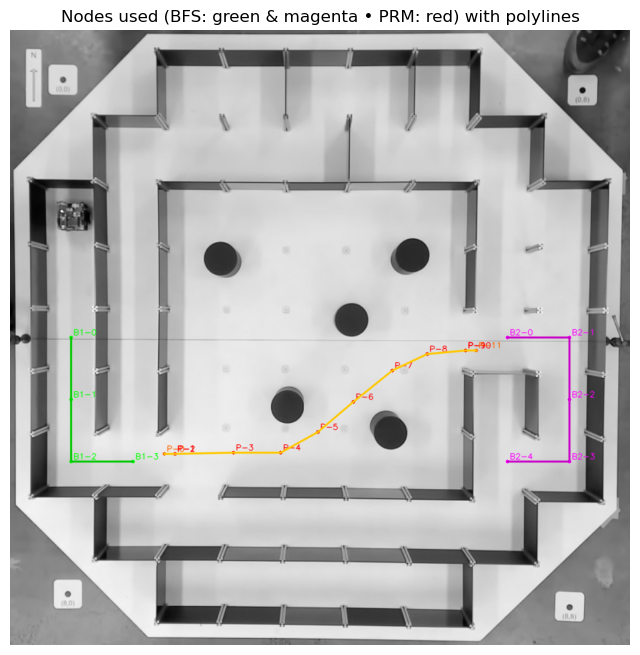

Encoded command string:
ffrff31r1f170l1f137r29f124r11f135l2f145l13f112l20f112l5f31flfflf


In [73]:
# ================== INSPECT + COMMANDS FOR BFS & PRM ==================

import math

def poly_from_ids(graph, ids):
    """List of (x,y) points from a sequence of BFS node IDs."""
    if ids is None or len(ids) == 0: return []
    return [(graph.nodes[i].x, graph.nodes[i].y) for i in ids]

def _angle_deg(p, q):
    """Absolute heading (deg) in image coords; −180..180 (0=+x/right)."""
    dx, dy = (q[0]-p[0], q[1]-p[1])
    return math.degrees(math.atan2(dy, dx))

def _turn_delta(prev, new):
    """Minimal signed delta in degrees: (+)left / (−)right."""
    d = (new - prev + 180.0) % 360.0 - 180.0
    return d

def poly_to_commands(poly, start_heading=None, dist_unit="px", fwd_round=1, turn_round=1):
    """
    Convert a polyline into relative commands:
      [('left', deg)|('right', deg)|('forward', dist), ...]
    Returns (commands, end_heading_deg)
    """
    if len(poly) < 2: 
        return [], start_heading if start_heading is not None else 0.0

    # segment headings and lengths
    heads = []
    lens  = []
    for i in range(len(poly)-1):
        a, b = poly[i], poly[i+1]
        heads.append(_angle_deg(a, b))
        lens.append(float(math.hypot(b[0]-a[0], b[1]-a[1])))

    cmds = []
    # initialize orientation
    curr = heads[0] if start_heading is None else float(start_heading)
    # if we gave a start heading, we’ll turn to the first segment
    turn0 = _turn_delta(curr, heads[0])
    if abs(turn0) > 1e-6:
        cmds.append(("left",  round(turn0, turn_round)) if turn0 > 0 
                                  else ("right", round(-turn0, turn_round)))
        curr = heads[0]

    # walk segments
    for L, th in zip(lens, heads):
        # re-orient if needed (only at inflections)
        d = _turn_delta(curr, th)
        if abs(d) > 1.0:  # ignore tiny wiggles
            cmds.append(("left",  round(d, turn_round)) if d > 0 
                                  else ("right", round(-d, turn_round)))
            curr = th
        cmds.append(("forward", round(L, fwd_round), dist_unit))

    return cmds, curr

# -------- build the three polylines used by the hybrid --------
bfs_poly_1 = poly_from_ids(bfs_graph, path_ids_1)
prm_poly   = [gate_out_S, gate_in_S] + prm_core + [gate_in_G, gate_out_G]
bfs_poly_2 = poly_from_ids(bfs_graph, path_ids_2)

# -------- generate commands per leg (you can change start_heading if your robot has one) --------
cmds_bfs_1, h1_end = poly_to_commands(bfs_poly_1, start_heading=None)
cmds_prm,   h2_end = poly_to_commands(prm_poly,   start_heading=h1_end)
cmds_bfs_2, _      = poly_to_commands(bfs_poly_2, start_heading=h2_end)

# -------- print nicely --------
def print_cmds(title, cmds):
    print(f"\n{title}")
    for i, c in enumerate(cmds, 1):
        if c[0] == "forward":
            _, dist, u = c
            print(f"{i:02d}. forward {dist} {u}")
        else:
            # ('left'|'right', deg)
            print(f"{i:02d}. {c[0]} {c[1]}°")

print_cmds("BFS leg 1 (start → gate S OUT)", cmds_bfs_1)
print_cmds("PRM leg (gate S IN → gate G IN, incl. pierce segments)", cmds_prm)
print_cmds("BFS leg 2 (gate G OUT → goal)", cmds_bfs_2)

# -------- overlay all used nodes with labels --------
vis_nodes = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)

# BFS leg 1 nodes: label as B1-0, B1-1, ...
for k, (x,y) in enumerate(bfs_poly_1):
    cv2.circle(vis_nodes, (int(x),int(y)), 3, (0,255,0), -1)
    cv2.putText(vis_nodes, f"B1-{k}", (int(x)+4,int(y)-4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,0), 1, cv2.LINE_AA)

# PRM nodes: include pierce points & core; label as P-0..N
for k, (x,y) in enumerate(prm_poly):
    col = (0,0,255) if 0 < k < len(prm_poly)-1 else (0,100,255)  # inner core red, pierces amber
    cv2.circle(vis_nodes, (int(x),int(y)), 3, col, -1)
    cv2.putText(vis_nodes, f"P-{k}", (int(x)+4,int(y)-4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, col, 1, cv2.LINE_AA)

# BFS leg 2 nodes: label as B2-0, B2-1, ...
for k, (x,y) in enumerate(bfs_poly_2):
    cv2.circle(vis_nodes, (int(x),int(y)), 3, (255,0,255), -1)
    cv2.putText(vis_nodes, f"B2-{k}", (int(x)+4,int(y)-4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,0,255), 1, cv2.LINE_AA)

# draw the three polylines for clarity
def draw_poly(im, poly, color):
    for p,q in zip(poly[:-1], poly[1:]):
        cv2.line(im, (int(p[0]),int(p[1])), (int(q[0]),int(q[1])), color, 2, cv2.LINE_AA)

draw_poly(vis_nodes, bfs_poly_1, (0,200,0))
draw_poly(vis_nodes, prm_poly,   (0,200,255))
draw_poly(vis_nodes, bfs_poly_2, (200,0,200))

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(vis_nodes, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title("Nodes used (BFS: green & magenta • PRM: red) with polylines")
plt.show()

# ===== Convert BFS/PRM commands (px) -> mm and encode to string =====
import statistics as stats

# 1) Estimate one-grid-step in pixels (median of BFS forward lengths)
def _estimate_cell_px(cmds_bfs_1, cmds_bfs_2):
    fpx = [c[1] for c in (cmds_bfs_1 + cmds_bfs_2) if c[0] == 'forward']
    if fpx:
        return float(stats.median(fpx))
    # fallback to wall grid spacing if available, else avoid div-by-zero
    try:
        return float((wall_grid_spacing_x + wall_grid_spacing_y) / 2.0)
    except Exception:
        return 1.0

cell_px_est = _estimate_cell_px(cmds_bfs_1, cmds_bfs_2)   # pixels per 180 mm
px_to_mm = 180.0 / cell_px_est                            # mm per pixel

# 2) Convert command list from px->mm (turns already in degrees)
def cmds_px_to_mm(cmds, scale_mm_per_px):
    out = []
    for c in cmds:
        if c[0] == 'forward':
            out.append(('forward', float(c[1]) * scale_mm_per_px, 'mm'))
        else:
            # ('left'/'right', degrees)
            out.append((c[0], float(c[1])))
    return out

cmds_bfs_1_mm = cmds_px_to_mm(cmds_bfs_1, px_to_mm)
cmds_prm_mm   = cmds_px_to_mm(cmds_prm,   px_to_mm)
cmds_bfs_2_mm = cmds_px_to_mm(cmds_bfs_2, px_to_mm)

# 3) Encoder (same interface you wanted)
def encode_cmds_to_string(*legs, cell_mm=180.0, tol_mm=10.0, tol_deg=5.0,
                          split_180=True, min_forward_mm=1.0):
    tokens = []
    def enc_forward(dmm):
        if dmm < min_forward_mm: return
        if abs(dmm - cell_mm) <= tol_mm:
            tokens.append('f')
        else:
            tokens.append(f"f{int(round(dmm))}")
    def enc_turn(side, deg):
        d = abs(float(deg)); s = 'r' if side == 'right' else 'l'
        if abs(d - 90.0) <= tol_deg:
            tokens.append(s)
        elif split_180 and abs(d - 180.0) <= tol_deg:
            tokens.extend([s, s])
        else:
            tokens.append(f"{s}{int(round(d))}")
    for leg in legs:
        for c in leg:
            if c[0] == 'forward':
                enc_forward(float(c[1]))
            else:
                enc_turn(c[0], c[1])
    return ''.join(tokens), tokens

# 4) Build strings
s_bfs1, _ = encode_cmds_to_string(cmds_bfs_1_mm, cell_mm=180.0)
s_prm,  _ = encode_cmds_to_string(cmds_prm_mm,   cell_mm=180.0)
s_bfs2, _ = encode_cmds_to_string(cmds_bfs_2_mm, cell_mm=180.0)

cmd_string = s_bfs1 + s_prm + s_bfs2
print("Encoded command string:")
print(cmd_string)



In [74]:
s1, _ = encode_cmds_to_string(cmds_bfs_1_mm)
s2, _ = encode_cmds_to_string(cmds_prm_mm)
s3, _ = encode_cmds_to_string(cmds_bfs_2_mm)
cmd_string_grouped = s1 + s2 + s3   # or add separators if you like: f"{s1}|{s2}|{s3}"
print("Grouped:", cmd_string_grouped)


Grouped: ffrff31r1f170l1f137r29f124r11f135l2f145l13f112l20f112l5f31flfflf
